In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates


E:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
E:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed_weather_labeled.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

Index(['vintage', 'country', 'description', 'points', 'price', 'province',
       'region_1', 'taster_name', 'variety', 'winery',
       'similarityTop3WinesByVariety', 'word_count', 'tf_grouped_1',
       'tf_grouped_2', 'tf_grouped_3', 'tfIdf_grouped_1', 'tfIdf_grouped_2',
       'tfIdf_grouped_3', 'tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',
       'tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3', 'pr_5',
       'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8',
       'tas_9'],
      dtype='object')

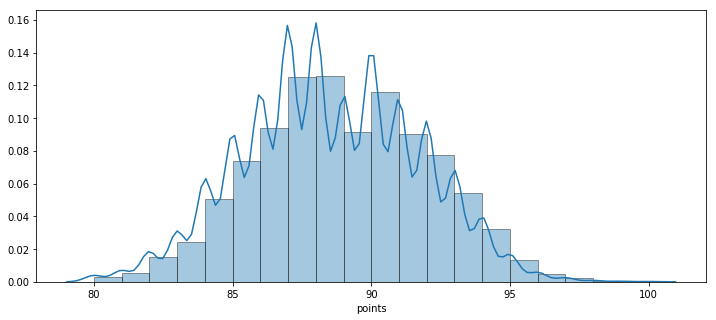

In [3]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

In [4]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  
bins

array([ 80.,  87.,  90., 100.])

10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

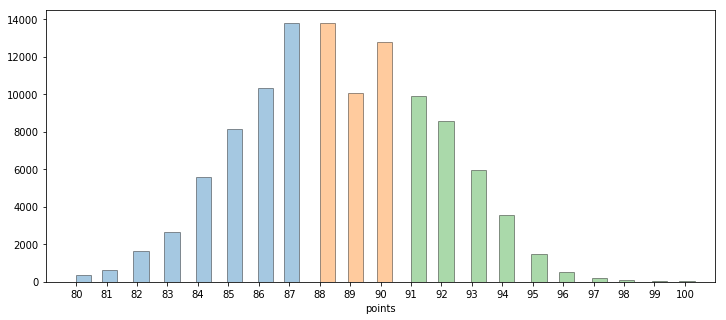

In [5]:
#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + tfGroup + word2vec

# DUMMY CLASSIFIER = BASELINE

In [ ]:
X = wine_base.loc[:,features]
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
classifier = DummyClassifier("stratified")
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)  
acc = accuracy_score(y_test,y_pred)
weightedPrec = precision_score(y_test,y_pred,average="weighted")
print(classification_report(y_test, y_pred, target_names=labels))

# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")

    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
features = ["price","vintage"] #basic + word2vec + word_count...
depth = 4
clf = decTree(features,depth,wine_base)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Classifier using sparse matrix

In [ ]:
def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features+["description"]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    #compute countvectorizer
    vect = CountVectorizer(min_df=5)
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

In [ ]:
#change the input and compute

features = ["price"] #basic #+ word + tfGroup + word2vec
depth = 3
test_size = 0.30
clf = sparseMatrixRep(features,depth,wine_base,test_size)

In [ ]:
#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [ ]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            for name,importance in c:
                temp[name] = importance
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]

# test stuff based on countries

In [6]:
countries = wine_base["country"].unique().tolist()
countries

[8, 5, 10, 4, 2, 11, 6, 1, 3, 9, 7, 0]

In [7]:
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))

8 4639
5 1939
10 5510
4 17931
2 2784
11 48572
6 16699
1 2086
3 4046
9 1241
7 1206
0 3380


In [8]:
test = wine_base["country"].unique().tolist()
test

[8, 5, 10, 4, 2, 11, 6, 1, 3, 9, 7, 0]

In [55]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points","description"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
    #set many different combinations
    args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
    allfeatures = basic + word + word2vec + tfGroup 
    combos = {"depth":[2,3,4,5,6],"args":args}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    print(type(data))
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeatures: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el+["country","category"]
        print("datalop",type(data))
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = X_train["category"]
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                for name,importance in c:
                    temp[name] = importance
                for feat in allfeatures:
                    if feat not in el:
                        rowData.append(100) #100 is an impossible value not to be taken into account
                    else:
                        rowData.append(temp[feat])
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [56]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + tfGroup + word2vec


result = testByCountry(wine_base,countries)

<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

datalop <class 'pandas.core.frame.DataFrame'>


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
result = result.sort_values(["precision","f1","accuracy"],ascending=False)
result

,algorithm,ObjectiveCountry,input,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,...,feat_province,feat_region_1,feat_taster_name,feat_variety,feat_winery,feat_word_count,feat_similarityTop3WinesByVariety,feat_tf_grouped_1,feat_tf_grouped_2,feat_tf_grouped_3
8,decTree,3,"[price, word_count, country, category]",0.761018,0.728621,0.740264,5,0.506667,0.674556,0.578680,...,100.000000,100.000000,100.000000,100.000000,100.000000,0.220698,100.000000,100.000000,100.000000,100.000000
16,decTree,3,"[price, vintage, province, region_1, taster_na...",0.759386,0.705635,0.720397,3,0.600000,0.461538,0.521739,...,0.000000,0.000000,0.076084,0.000000,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000
11,decTree,3,"[price, vintage, province, region_1, taster_na...",0.759386,0.705635,0.720397,3,0.600000,0.461538,0.521739,...,0.000000,0.000000,0.076084,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
7,decTree,3,"[price, word_count, country, category]",0.757136,0.718735,0.732052,4,0.531486,0.624260,0.574150,...,100.000000,100.000000,100.000000,100.000000,100.000000,0.212848,100.000000,100.000000,100.000000,100.000000
9,decTree,3,"[price, word_count, country, category]",0.752856,0.732081,0.739606,6,0.483936,0.713018,0.576555,...,100.000000,100.000000,100.000000,100.000000,100.000000,0.231704,100.000000,100.000000,100.000000,100.000000
14,decTree,3,"[price, vintage, province, region_1, taster_na...",0.751701,0.699456,0.715948,6,0.507109,0.633136,0.563158,...,0.022199,0.024663,0.097252,0.000670,0.001295,100.000000,100.000000,100.000000,100.000000,100.000000
19,decTree,3,"[price, vintage, province, region_1, taster_na...",0.751701,0.699456,0.715948,6,0.507109,0.633136,0.563158,...,0.017915,0.021011,0.093846,0.000728,0.000855,100.000000,100.000000,0.005038,0.005682,0.008546
6,decTree,3,"[price, word_count, country, category]",0.750910,0.710826,0.724421,3,0.458647,0.721893,0.560920,...,100.000000,100.000000,100.000000,100.000000,100.000000,0.160747,100.000000,100.000000,100.000000,100.000000
21,decTree,3,"[price, vintage, province, region_1, taster_na...",0.746141,0.703658,0.716443,3,0.600000,0.461538,0.521739,...,0.000000,0.000000,0.051819,0.000000,0.000000,100.000000,0.030755,100.000000,100.000000,100.000000
26,decTree,3,"[price, vintage, province, region_1, taster_na...",0.746141,0.703658,0.716443,3,0.600000,0.461538,0.521739,...,0.000000,0.000000,0.051819,0.000000,0.000000,100.000000,0.030755,0.000000,0.000000,0.000000


# plots


In [ ]:
#plot scatter plot for visualizing bins by color

In [ ]:
#plot radar plot to visualize most important features for regression

In [ ]:
#plot radar plot for features in dectree

In [ ]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))

categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(2,2,row+1, polar=True, )
 
# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Ind1
values=df.loc[row].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
ax.fill(angles, values, color=color, alpha=0.4)
 
# Add a title
plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
